In [1]:
%pip install ipynb
import os
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from matplotlib.colors import LogNorm
import heapq as heap
from pprint import pprint

# Constants
MOTIF_MATRIX_IMAGE = '../res/motif_matrix.png'
TEMPORAL_MOTIF_EXTRACTOR_PATH = "/home/aakyildiz/snap/examples/temporalmotifs/temporalmotifsmain"

Note: you may need to restart the kernel to use updated packages.


# Utility functions

In [2]:
def split_graph_by_period(input_graph_path, output_path, time_period):
    '''
    Splits a temporal graph into multiple temporal graphs each taking up `time_period` seconds
    
    input_graph_path: the location of the edgelist that is space delimeted and contains (u,v,timestamp) tuples
    output_path: the path in which the garphs will be printed out
    
    Will produce the following files/folders
        {output_path}/periodical_graphs/period_{time_period}/0to{time_period}/0to{time_period}.edgelist
        {output_path}/periodical_graphs/period_{time_period}/0to{time_period}/{time_period}to{2*time_period}.edgelist
        ...
    
    Returns:
        The path of the location of the partitioned graphs (path/to/period_{time_period})
    
    '''
    # make output directory if it's not already made
    output_path+='/periodical_graphs'
    res = os.popen("mkdir -p "+output_path)
    graph = pd.read_csv(input_graph_path, header=None, index_col = False, sep=' ')
    graph.columns = ['u', 'v', 'time']
    graph.sort_values('time', inplace=True)
    start_time = graph.iloc[0]['time']
    end_time = graph.iloc[graph.shape[0]-1]['time']
    output_period_folder = output_path+"/period_"+str(time_period)
    for i in range(start_time, end_time, time_period):
        part_name = str(i)+"to"+str(i+time_period)
        output_part_folder = output_period_folder+"/"+part_name+"/"
        res = os.popen("mkdir -p "+output_part_folder)
        this_g = graph[graph['time'] >= i]
        this_g = this_g[this_g['time']<i+time_period]
        this_g.to_csv(output_part_folder+part_name+'.edgelist', sep=' ', header=False, index=False)
    return output_period_folder

## Extract temporal motifs from a graph 

In [3]:
def extract_temporal_motifs(input_graph_path, output_location, numThreads=32, delta=60):
    '''
    Given a single input graph and an output motifs matrix locaion, will print the 
    motifs matrix and return the motifs as an matrix
    '''
    #parameters
    numThreads = str(numThreads)
    delta = str(delta)
    
    #out_path = input_graph_path.split(".")[0] + "-delta=" + delta + ".temporalmotifs"
    command = TEMPORAL_MOTIF_EXTRACTOR_PATH + " -i:" + input_graph_path \
                                            + " -nt:"  + numThreads\
                                            + " -delta:"  + delta\
                                            + " -o:" + output_location
    res = os.popen(command)
    res.read()
    motifs = []
    with open(output_location, "r") as f:
        for line in f:
            counts = line.replace("\n", "").split(" ")
            motifs.append([float(count) for count in counts])
    display_motifs_heatmap(motifs, image_path=MOTIF_MATRIX_IMAGE, figname=output_location + ".png", title=None)
    return motifs

## Motif heatmap viewer

In [4]:
def display_motifs_heatmap(motifs, image_path=None, figname=None, title=None):
    mmax = np.max(motifs)
    mmin = 1 #np.min(motifs)
    print(mmax, mmin)
    
    # open the image 
    # Import image and get x and y extents
    def remove_ticks(ax):
        ax.tick_params(left=False, bottom=False)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])

    cmap = plt.cm.get_cmap('Blues', len(np.unique(motifs)))
    if image_path is not None:
        img = plt.imread(image_path)
        x_ext = img.shape[1]/100.0
        y_ext = img.shape[0]/100.0
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        ax2.imshow(img, alpha=1, aspect='auto', extent=(0,x_ext,0,y_ext))
        ax2.imshow(motifs, cmap=cmap, alpha = 0.3, aspect='auto', extent=(0,x_ext,0,y_ext))
        ax2.set_aspect('equal')
        remove_ticks(ax2)
    else:
        fig, ax1 = plt.subplots()
    yticklabels = [str(i) for i in reversed(range(len(motifs)))]
    sns.heatmap(motifs, cmap=cmap, annot=True, fmt=".1f", ax=ax1, yticklabels=yticklabels, norm=LogNorm(vmin=mmin, vmax=mmax))    
    ax1.set_aspect('equal')
    fig.set_size_inches(12,5)
    remove_ticks(ax1)
    if title is not None:
        fig.suptitle(title, fontsize=20)
    plt.show()
    if figname != None:
        fig.savefig(figname, dpi=300, bbox_inches='tight')


## Evolutionary temporal viewer

In [5]:
def evolutionary_temporal_motif_explorer(input_graph_path, time_period, delta, partitioned_graphs_location):
    '''
    Takes a graph and produces time-evolutionary temporal motifs based on the input and produces the 
    output temporal motifs
    '''
    def sort_folders_by_number(folders):
        start_and_folder = [(int(a.split('to')[0]), a) for a in folders]
        return [folder for _, folder in sorted(start_and_folder)]
    location = split_graph_by_period(input_graph_path, partitioned_graphs_location, time_period)
    for part_folder in sort_folders_by_number(list(os.listdir(location))):
        files_prefix = location+'/'+part_folder+'/'+part_folder
        input_graph = files_prefix+'.edgelist'
        temporal_motifs_name=files_prefix+'-delta='+str(delta)
        temporal_motifs_matrix = temporal_motifs_name+'.temporalmotifs'
        emporal_motifs_figure=temporal_motifs_name+'.png'
        display_motifs_heatmap(extract_temporal_motifs(input_graph, output_location=temporal_motifs_matrix,delta=delta),
                               MOTIF_MATRIX_IMAGE, figname=emporal_motifs_figure, title=part_folder)

418136 1


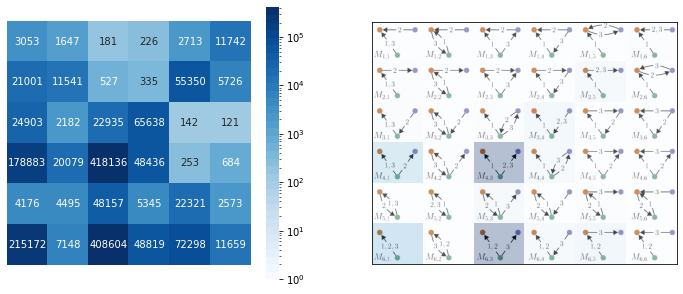

In [57]:
input_graph_path = "/DATA/7A/assets/erc721networks/Rarible/Rarible.edgelist"
time_period = 60*60*24*90 # 90 day periods 
#output_folder = "/DATA/7A/assets/erc721networks/GodsUnchainedCards/"
output_folder = "/DATA/7A/assets/erc721networks/Rarible/Rarible"
hour = 3600
minute = 60
motifs = extract_temporal_motifs(input_graph_path, output_folder + ".temporalmotifs", 32, hour)
#evolutionary_temporal_motif_explorer(input_graph_path, time_period, delta=60)
#evolutionary_temporal_motif_explorer(input_graph_path, time_period, delta=3600, partitioned_graphs_location=output_folder)

# Dapp motif visualizer

## load categories

In [6]:
categories = {
    "marketplace" : 0,
    "games" : 1,
    "exchange" : 2,
    "defi" : 3,
    "social": 4,
    "gambling": 5
}

## load dapps

In [7]:
#load dapps
dapps = [
    {
        "path": "/DATA/7A/assets/erc721networks/Rarible/Rarible.edgelist", 
        "category": categories["marketplace"],
        "id": 0
    },
    {
        "path": "/DATA/7A/assets/erc721networks/SuperRare/SuperRare.edgelist",
        "category": categories["marketplace"],
        "id": 1
    },
    {
        "path": "/DATA/7A/assets/erc721networks/DecentralandLAND/DecentralandLAND.edgelist",
        "category": categories["marketplace"],
        "id": 2
    },
    {
        "path": "/DATA/7A/assets/erc721networks/CryptoKitties/CryptoKitties.edgelist",
        "category": categories["games"],
        "id": 0
    },
    {
        "path": "/DATA/7A/assets/erc721networks/GodsUnchainedCards/GodsUnchainedCards.edgelist",
        "category": categories["games"],
         "id": 1
    },
    {
        "path": "/DATA/7A/assets/erc721networks/Sorare/Sorare.edgelist",
        "category": categories["games"],
        "id": 2
    },
    {
        "path": "/DATA/7A/assets/erc20networks/UniswapV2/UniswapV2.edgelist",
        "category": categories["exchange"],
        "id": 0
    },
    {
        "path": "/DATA/7A/assets/erc20networks/SushiToken/SushiToken.edgelist",
        "category": categories["exchange"],
        "id": 1
    },
    {
        "path": "/DATA/7A/assets/erc20networks/Uniswap/Uniswap.edgelist",
        "category": categories["exchange"],
        "id": 2
    },
    {
        "path": "/DATA/7A/assets/erc20networks/Compound/Compound.edgelist",
        "category": categories["defi"],
        "id": 0
    },
    {
        "path": "/DATA/7A/assets/erc20networks/yearn.finance/yearn.finance.edgelist",
        "category": categories["defi"],
        "id": 1
    },
    {
        "path": "/DATA/7A/assets/erc20networks/ChiGastokenby1inch/ChiGastokenby1inch.edgelist",
        "category": categories["defi"],
        "id": 2
    },
    {
        "path": "/DATA/7A/assets/erc20networks/LivepeerToken/LivepeerToken.edgelist",
        "category": categories["social"],
        "id": 0
    },
    {
        "path": "/DATA/7A/assets/erc20networks/Minds/Minds.edgelist",
        "category": categories["social"],
        "id": 1
    },
    #{
    #    "path": "/DATA/7A/assets/erc20networks/Minds/Minds.edgelist",
    #    "category": categories["social"],
    #    "id": 2
    #},
    {
        "path": "/DATA/7A/assets/erc20networks/BetterBetting/BetterBetting.edgelist",
        "category": categories["gambling"],
        "id": 0
    },
]

## get motif frequencies of dapps

/DATA/7A/assets/erc721networks/Rarible/Rarible.edgelist
418327.0 1


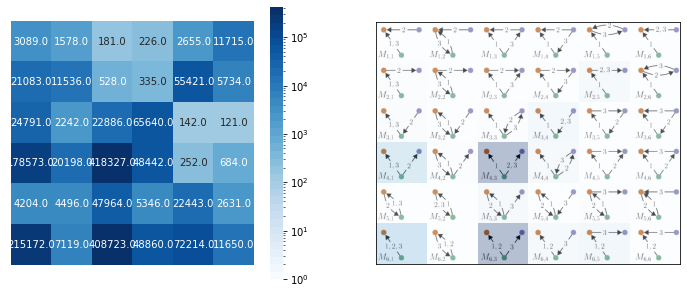

/DATA/7A/assets/erc721networks/SuperRare/SuperRare.edgelist
552678.0 1


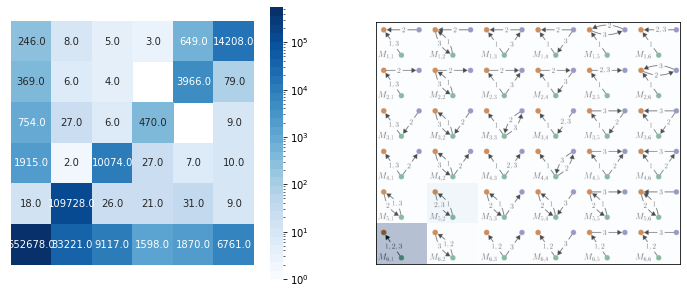

/DATA/7A/assets/erc721networks/DecentralandLAND/DecentralandLAND.edgelist
1916483249.0 1


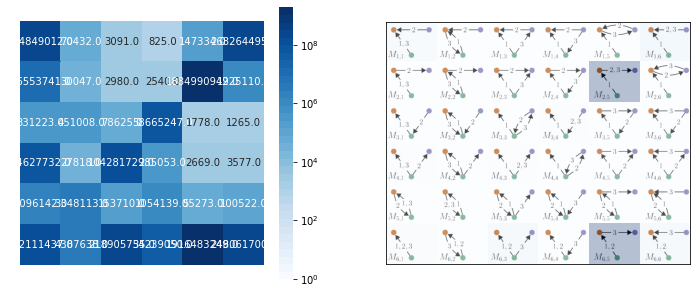

/DATA/7A/assets/erc721networks/CryptoKitties/CryptoKitties.edgelist
2095470160.0 1


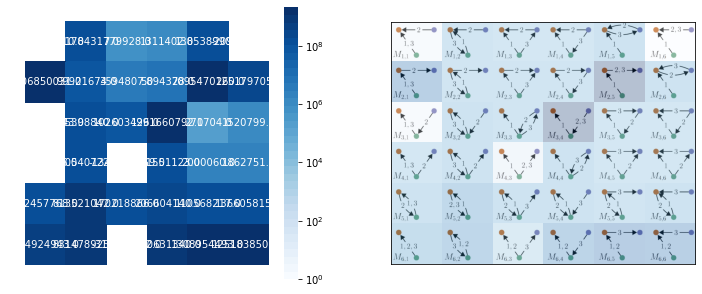

/DATA/7A/assets/erc721networks/GodsUnchainedCards/GodsUnchainedCards.edgelist
1878675576.0 1


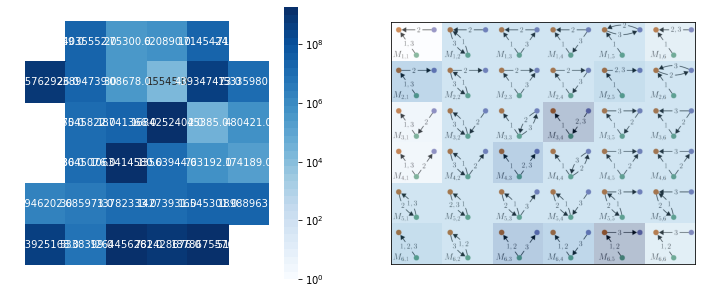

/DATA/7A/assets/erc721networks/Sorare/Sorare.edgelist
485914030.0 1


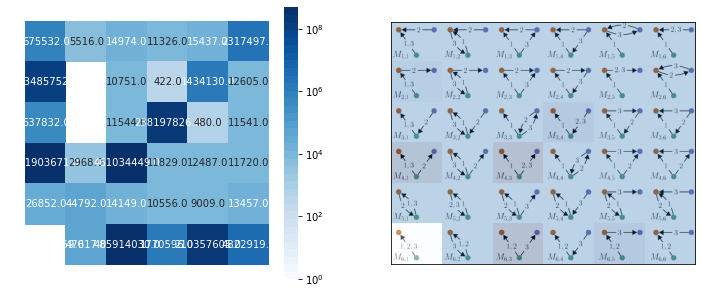

/DATA/7A/assets/erc20networks/UniswapV2/UniswapV2.edgelist
565702398.0 1


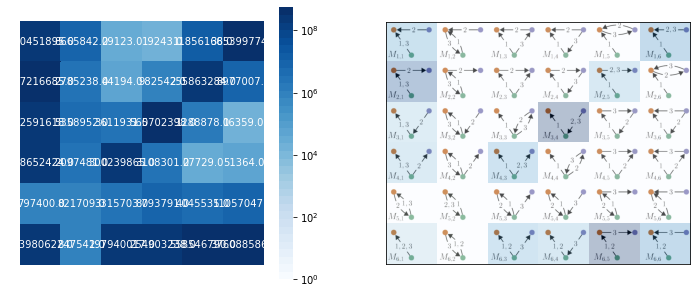

/DATA/7A/assets/erc20networks/SushiToken/SushiToken.edgelist
1657789350.0 1


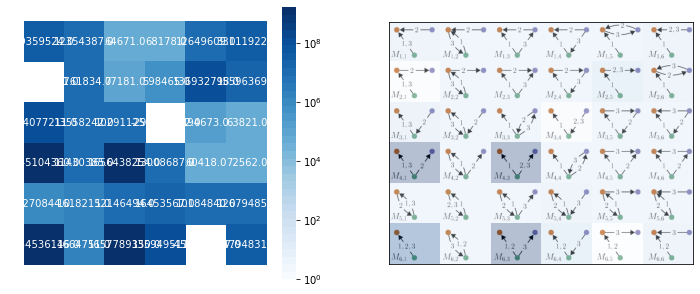

/DATA/7A/assets/erc20networks/Uniswap/Uniswap.edgelist
141398395.0 1


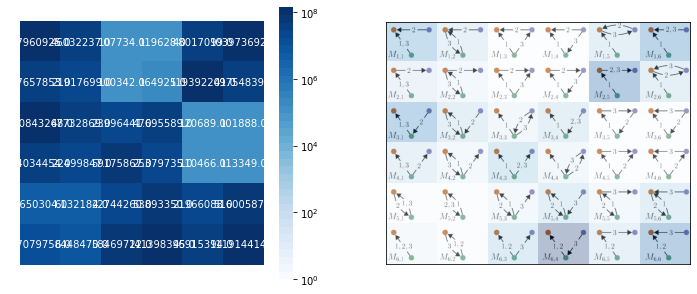

/DATA/7A/assets/erc20networks/Compound/Compound.edgelist
29158511.0 1


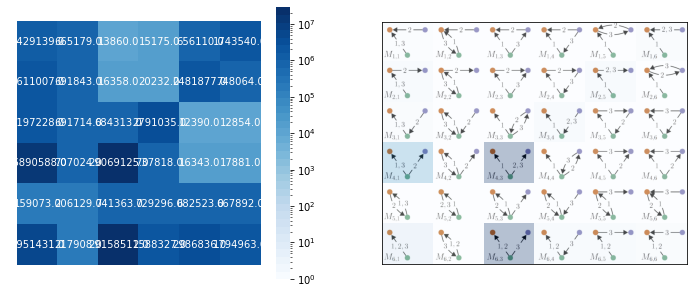

/DATA/7A/assets/erc20networks/yearn.finance/yearn.finance.edgelist
25062485.0 1


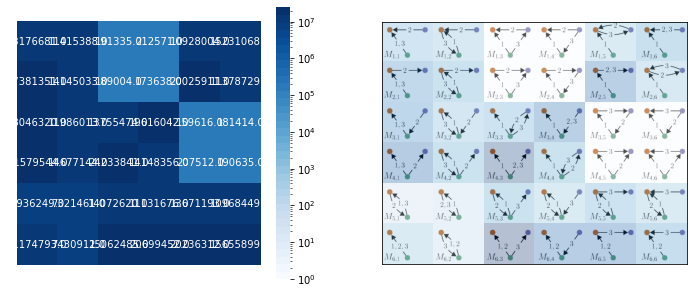

/DATA/7A/assets/erc20networks/ChiGastokenby1inch/ChiGastokenby1inch.edgelist
629664368.0 1


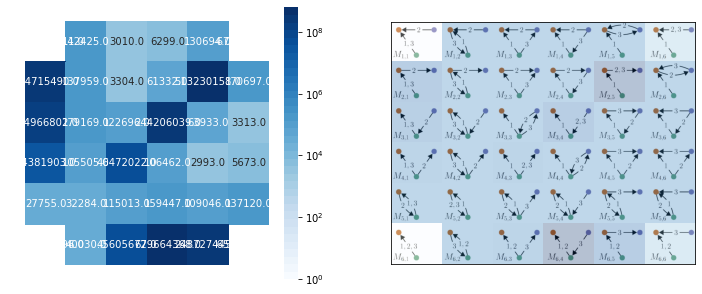

/DATA/7A/assets/erc20networks/LivepeerToken/LivepeerToken.edgelist
1463959612.0 1


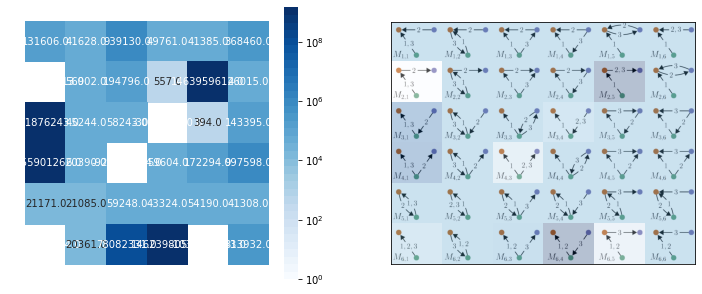

/DATA/7A/assets/erc20networks/Minds/Minds.edgelist
48753.0 1


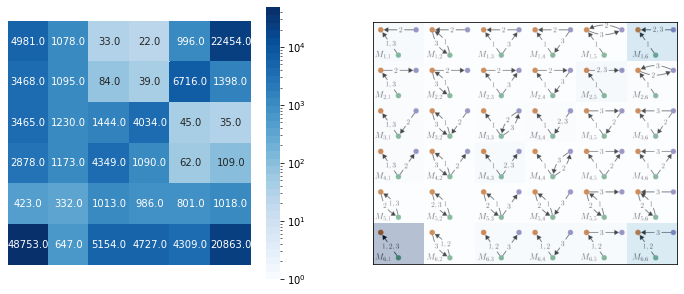

/DATA/7A/assets/erc20networks/BetterBetting/BetterBetting.edgelist
142824.0 1


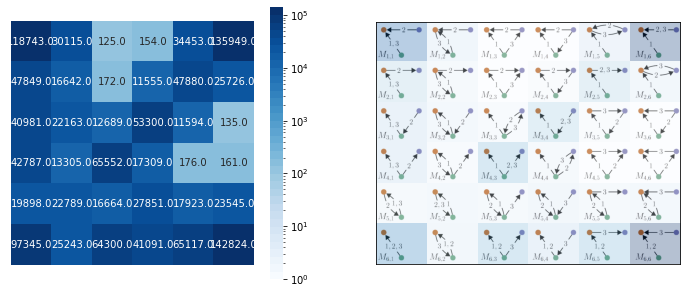

In [8]:
hour = 3600
for i in range(len(dapps)):
    print(dapps[i]["path"])
    dapps[i]["motifs"] = extract_temporal_motifs(dapps[i]["path"], dapps[i]["path"] + ".temporalmotifs", 32, hour)    
    

## get nth highest ranked motifs

In [67]:
def get_nth_largest(motifs, nth=5):
    ranks = []
    heap.heapify(ranks)

    for i in range(len(motifs)):
        row = motifs[i]
        for j in range(len(row)):
            val = row[j]
            if len(ranks) < nth:
                heap.heappush(ranks, (val, i, j))
            else:
                heap.heappushpop(ranks, (val, i, j))
    return ranks

nth = 10
for i in range(len(dapps)):
    dapps[i]["ranks"] = get_nth_largest(dapps[i]["motifs"], nth)

## display highest ranked motifs per Dapp

36 18


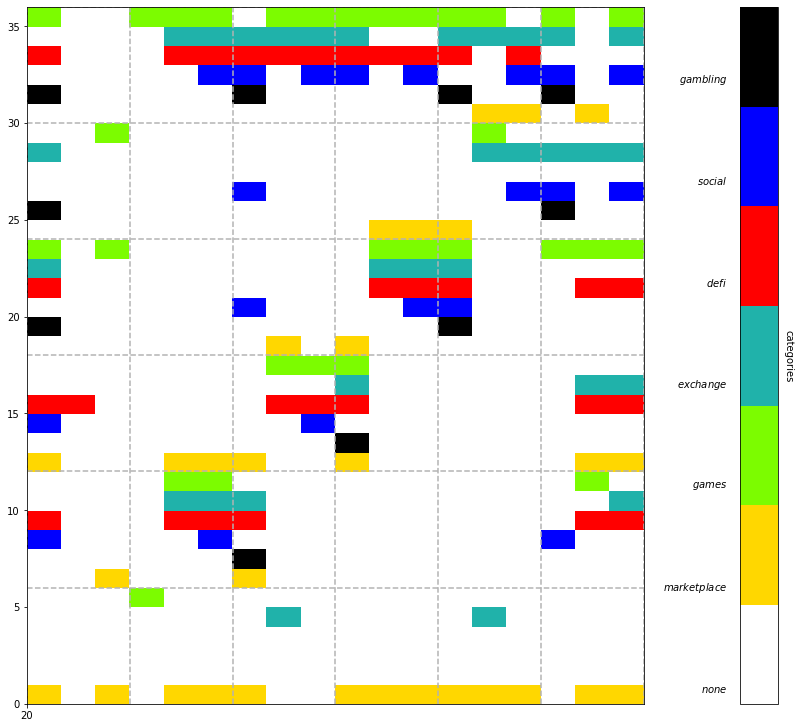

In [68]:
motifs_width = 6
motifs_length = 6
max_number_of_dapp_per_category = 3

def fill_map(ranks, mat, category, graph):
    for r in ranks:
        #print(r[1] * 5 + category, r[2] * 5 + graph, category)
        mat[(motifs_width - r[1] - 1) * len(categories) - category][r[2] * max_number_of_dapp_per_category - graph] = category + 1

def plot_map(colormaps, data):
    """
    Helper function to plot data with associated colormap.
    """
    
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * (nth + 1), nth),
                            constrained_layout=True, squeeze=False)
        
    #n = len(colormaps)
    #fig, axs = plt.subplots(1, n, figsize=(n * (nth-2) + 2, nth),
                            #constrained_layout=True, squeeze=False)

    for [ax, cmap] in zip(axs.flat, colormaps):
        vlines = np.linspace(0,len(data[0]),motifs_width+1)[1:]
        hlines = np.linspace(0,len(data), motifs_length+1)[1:]
        for xx in vlines:
            ax.axvline(xx, color='0.7', linestyle='--')
        for xx in hlines:
            ax.axhline(xx, color='0.7', linestyle='--')
        ax.axvline("20", color='1', linestyle='--')
        
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=6)
        cb = plt.colorbar(psm, ax=ax, label = "categories")
        cb.ax.get_yaxis().set_ticks([])
        for j, lab in enumerate(["$none$", "$marketplace$", "$games$", "$exchange$", "$defi$", "$social$", "$gambling$"]):
            cb.ax.text(-2, (7 * j + 1) / 8.0, lab, ha='right', va='center')
        cb.ax.get_yaxis().labelpad = 15
        cb.ax.set_ylabel('categories', rotation=270)
        
        #cb.set_ticklabels()

    plt.show()
    
mat = np.zeros((motifs_width * len(categories), motifs_length * max_number_of_dapp_per_category))
print(len(mat), len(mat[0]))

for dapp in dapps:
    fill_map(dapp["ranks"], mat, dapp["category"], dapp["id"])
np.set_printoptions(threshold=sys.maxsize)

cmap = ListedColormap(["white", "gold", "lawngreen", "lightseagreen", "red", "blue", "black"])
plot_map([cmap], mat)

In [ ]:
## Ideas
- collaborative filtering (motifs as films, dapps as users) to find the similarity of dapps.
    - which ones do you think should be similar (what can we analyze about this)

# JUNK

In [158]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.sampledata.periodic_table import elements
from bokeh.transform import dodge, factor_cmap

from bokeh.resources import INLINE
import bokeh.io
from bokeh import *
bokeh.io.output_notebook(INLINE)

output_file("periodic.html")

periods = ["I", "II", "III", "IV", "V", "VI", "VII"]
groups = [str(x) for x in range(1, 19)]

df = elements.copy()
print
df["atomic mass"] = df["atomic mass"].astype(str)
df["group"] = df["group"].astype(str)
df["period"] = [periods[x-1] for x in df.period]
df = df[df.group != "-"]
df = df[df.symbol != "Lr"]
df = df[df.symbol != "Lu"]

cmap = {
    "alkali metal"         : "#a6cee3",
    "alkaline earth metal" : "#1f78b4",
    "metal"                : "#d93b43",
    "halogen"              : "#999d9a",
    "metalloid"            : "#e08d49",
    "noble gas"            : "#eaeaea",
    "nonmetal"             : "#f1d4Af",
    "transition metal"     : "#599d7A",
}

source = ColumnDataSource(df)

p = figure(plot_width=900, plot_height=500, title="Periodic table (omitting LA and AC series)",
           x_range=groups, y_range=list(reversed(periods)), toolbar_location=None, tools="hover")

p.rect("group", "period", 0.95, 0.95, source=source, fill_alpha=0.6, legend_field="metal",
       color=factor_cmap('metal', palette=list(cmap.values()), factors=list(cmap.keys())))

text_props = {"source": source, "text_align": "left", "text_baseline": "middle"}

x = dodge("group", -0.4, range=p.x_range)

r = p.text(x=x, y="period", text="symbol", **text_props)
r.glyph.text_font_style="bold"

r = p.text(x=x, y=dodge("period", 0.3, range=p.y_range), text="atomic number", **text_props)
r.glyph.text_font_size="11px"

r = p.text(x=x, y=dodge("period", -0.35, range=p.y_range), text="name", **text_props)
r.glyph.text_font_size="7px"

r = p.text(x=x, y=dodge("period", -0.2, range=p.y_range), text="atomic mass", **text_props)
r.glyph.text_font_size="7px"

p.text(x=["3", "3"], y=["VI", "VII"], text=["LA", "AC"], text_align="center", text_baseline="middle")

#p.hover.tooltips = [
#    ("Name", "@name"),
#    ("Atomic number", "@{atomic number}"),
#    ("Atomic mass", "@{atomic mass}"),
#    ("Type", "@metal"),
#    ("CPK color", "$color[hex, swatch]:CPK"),
#    ("Electronic configuration", "@{electronic configuration}"),
#]

p.outline_line_color = None
p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_standoff = 0
p.legend.orientation = "horizontal"
p.legend.location ="top_center"

show(p)

Loading BokehJS ...

In [159]:
from sklearn.datasets import load_iris

In [162]:
iris = load_iris()
print(iris.target)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
